## 협업 필터링
기본적으로 다른 사용자들의 정보를 이용하여 내 취향을 예측

- 사용자 기반
    - 나와 비슷한 평점 패턴을 보이는 사람이 높게 평가한 아이템 추천
- 아이템 기반
    - 평점 패턴이 비슷한 아이템을 찾아서 추천
- 예측 모델 기반
    - 위 두개는 유사도 기반
    - 모델을 사용하여 추천


### 구현하는 방식
- 메모리 기반
    - 코사인 유사도, 피어슨 상관계수 등 사용
    - 가중치를 사용한 평균
    - KNN 방식도 포함
    - 이해, 설명 쉽지만 스케일하기 힘듬(평점 데이터의 부족)
- 모델 기반
    - 머신 러닝을 사용해 평점을 예측 (PCA, SVD, Matrix Factorization, 딥러닝 등)
        - 딥러닝의 경우 오토인코더를 사용해 차원 축소
    - 행렬의 차원을 줄여 평점 데이터의 부족 해결
    - 어떻게 동작하는지 설명하기 힘듬
    - 넥플릭스 프라이즈 -> RMSE를 지표로
    - SVD++에서는 SGD를 사용하여 학습

### 협업 필터링 평가
메모리 기반 협업 필터링
- 평점의 예측 없이 유사도 기반으로 추천할 아이템 결정
    - RMSE같은 평점 기반 평가는 불가
- 보통 Top-N(혹은 nDCG) 방식으로 평가
    - 사용자가 좋아한 아이템의 일부 남겨두었다가 추천 리스트에 포함되어 있는지 보는 방식
    - 추천 순서를 고려해서 평가하면 nDCG
모델 기반 협업 필터링
- 머신러닝 알고리즘들이 사용하는 평가함수를 통해 성능 평가 가능
- 메모리 기반에서 사용하는 Top-N, nDCG 방식도 가능
온라인 테스트 (A/B 테스트)
- 가장 좋은 방식은 실제 사용자에게 노출시키고 성능을 평하가는 것

### SurpriseLib
- 협업 필터링과 관련된 다양한 기능 제공
    - KNNBasic 객체 이용 사용자기반 혹은 아이템 기반 협업 필터링 구현
    - SVD or SVDpp 객체 사용가능
- 협업 필터링 알고리즘의 성능 평가를 위한 방법 제공
-

## 사용자 기반 협업 필터링

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
dummy_rating = pd.read_csv('https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/dummy_rating.csv', index_col=0)

In [ ]:
dummy_rating.head()

,scifi1,scifi2,scifi3,comedy1,comedy2,comedy3
user1,4.0,5.0,3.0,NaN,2.0,1.0
user2,5.0,3.0,3.0,2.0,2.0,NaN
user3,1.0,NaN,NaN,4.0,5.0,4.0
user4,NaN,2.0,1.0,4.0,NaN,3.0
user5,1.0,NaN,2.0,3.0,3.0,4.0


In [ ]:
dummy_rating.fillna(0, inplace=True)
dummy_rating

,scifi1,scifi2,scifi3,comedy1,comedy2,comedy3
user1,4.0,5.0,3.0,0.0,2.0,1.0
user2,5.0,3.0,3.0,2.0,2.0,0.0
user3,1.0,0.0,0.0,4.0,5.0,4.0
user4,0.0,2.0,1.0,4.0,0.0,3.0
user5,1.0,0.0,2.0,3.0,3.0,4.0


In [ ]:
# 피어슨 유사도 계산하기 위해 정규화

def standardize(row):
    new_row = (row - row.mean()) / (row.max() - row.min())
    return new_row

dummy_rating_std = dummy_rating.apply(standardize)
dummy_rating_std.head()

,scifi1,scifi2,scifi3,comedy1,comedy2,comedy3
user1,0.36,0.6,0.400000,-0.65,-0.08,-0.35
user2,0.56,0.2,0.400000,-0.15,-0.08,-0.60
user3,-0.24,-0.4,-0.600000,0.35,0.52,0.40
user4,-0.44,0.0,-0.266667,0.35,-0.48,0.15
user5,-0.24,-0.4,0.066667,0.10,0.12,0.40


In [ ]:
corrMatrix_wo_std = pd.DataFrame(
    cosine_similarity(dummy_rating),
    index=dummy_rating.index,
    columns=dummy_rating.index
)

corrMatrix_wo_std

,user1,user2,user3,user4,user5
user1,1.000000,0.906306,0.318696,0.393893,0.431834
user2,0.906306,1.000000,0.422891,0.434613,0.515716
user3,0.318696,0.422891,1.000000,0.671249,0.925138
user4,0.393893,0.434613,0.671249,1.000000,0.760117
user5,0.431834,0.515716,0.925138,0.760117,1.000000


In [ ]:
corrMatrix = pd.DataFrame(
    cosine_similarity(dummy_rating_std),
    index=dummy_rating_std.index,
    columns=dummy_rating_std.index
)

corrMatrix

,user1,user2,user3,user4,user5
user1,1.000000,0.764091,-0.837183,-0.577861,-0.736161
user2,0.764091,1.000000,-0.780626,-0.601483,-0.746852
user3,-0.837183,-0.780626,1.000000,0.233344,0.641732
user4,-0.577861,-0.601483,0.233344,1.000000,0.245501
user5,-0.736161,-0.746852,0.641732,0.245501,1.000000


In [ ]:
def get_similar(userId):
    similar_score = corrMatrix[userId]
    similar_score = similar_score.sort_values(ascending=False)
    return similar_score

In [ ]:
scifi_lover = "user1"
similar_users = get_similar(scifi_lover)
similar_users.head(10)

user1    1.000000
user2    0.764091
user4   -0.577861
user5   -0.736161
user3   -0.837183
Name: user1, dtype: float64

## 무비렌즈 데이터를 가지고 사용자 협업 필터링을 구현한다

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811608 sha256=39f171d354c8755eca4e6a34acc33bcc2d5f9f9208b0e9a4af880cbe58d99908
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from surprise import Dataset
from surprise import Reader

from collections import defaultdict
import numpy as np
import pandas as pd

In [ ]:
movies = pd.read_csv("https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/movies.csv")
ratings = pd.read_csv("https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/ratings.csv")

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
movie_ratings = pd.merge(movies, ratings, left_on="movieId", right_on="movieId")

In [ ]:
movie_ratings.shape

(100004, 6)

데이터 분석

In [ ]:
# 영화 수
movie_ratings['movieId'].nunique()

9066

In [ ]:
# 영화별 평점 정보
movie_rating_summary = movie_ratings[["movieId", "rating"]].groupby(["movieId"]).agg(["count", "median", "mean"])
movie_rating_summary.head()

rating                 
         count median      mean
movieId                        
1          247    4.0  3.872470
2          107    3.0  3.401869
3           59    3.0  3.161017
4           13    3.0  2.384615
5           56    3.0  3.267857

In [ ]:
movie_rating_summary.columns

MultiIndex([('rating',  'count'),
            ('rating', 'median'),
            ('rating',   'mean')],
           )

In [ ]:
movie_rating_summary.columns = ["count", "median", "mean"]

In [ ]:
movie_rating_summary.sort_values("count", ascending=False).head(10)

,count,median,mean
movieId,,,
356,341,4.0,4.054252
296,324,4.5,4.256173
318,311,5.0,4.487138
593,304,4.0,4.138158
260,291,4.5,4.221649
480,274,4.0,3.706204
2571,259,4.5,4.183398
1,247,4.0,3.872470
527,244,4.5,4.303279


In [ ]:
movie_rating_summary.sort_values("mean", ascending=False).head(10)

,count,median,mean
movieId,,,
163949,1,5.0,5.0
71180,1,5.0,5.0
51471,1,5.0,5.0
52617,1,5.0,5.0
53887,1,5.0,5.0
54251,1,5.0,5.0
54328,1,5.0,5.0
55555,1,5.0,5.0
56869,1,5.0,5.0


In [ ]:
movie_rating_summary[movie_rating_summary['count'] > 100].sort_values("mean", ascending=False).head()

,count,median,mean
movieId,,,
858,200,5.0,4.487500
318,311,5.0,4.487138
1221,135,5.0,4.385185
50,201,4.5,4.370647
527,244,4.5,4.303279


<ipython-input-33-feb230fce458>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=movie_rating_summary['mean'], kde=True, color='r')


<Axes: xlabel='mean', ylabel='Density'>

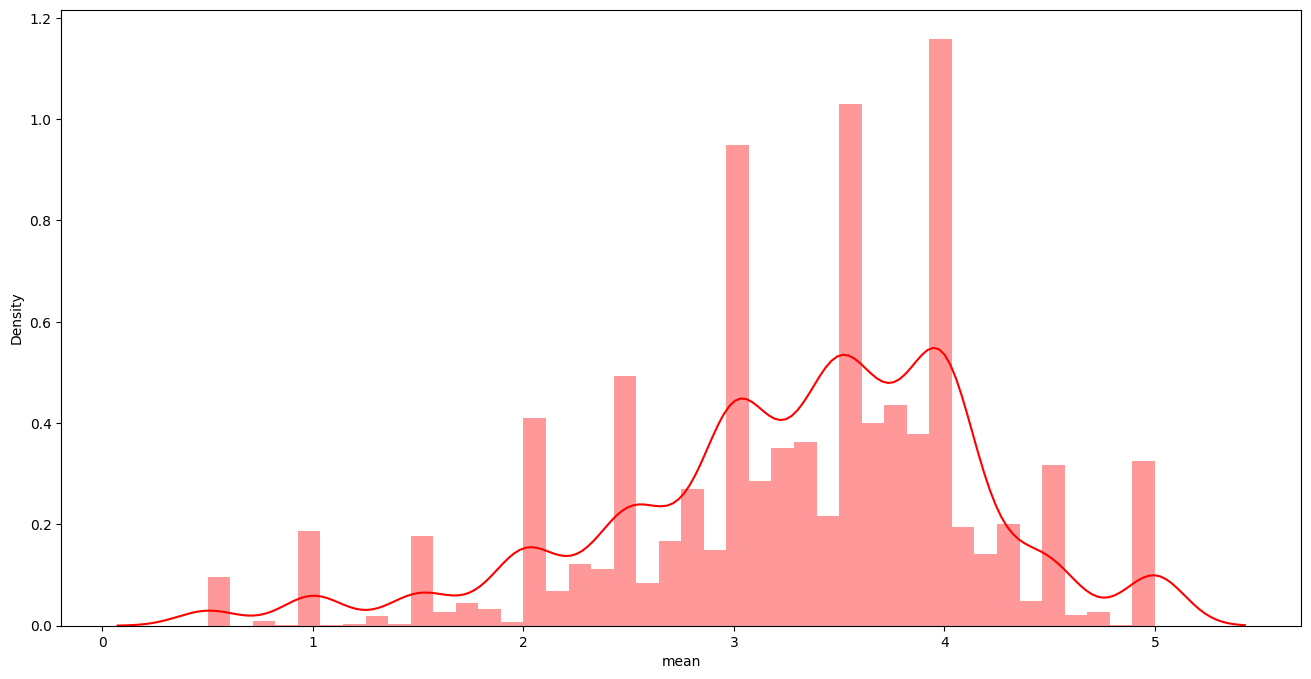

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
sns.distplot(a=movie_rating_summary['mean'], kde=True, color='r')

<ipython-input-34-90d24f3d5717>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=movie_rating_summary['count'], color='g')


<Axes: xlabel='count', ylabel='Density'>

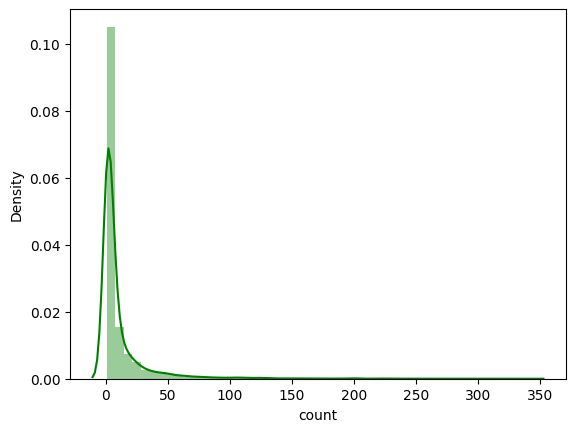

In [ ]:
sns.distplot(a=movie_rating_summary['count'], color='g')

In [ ]:
movie_ratings['userId'].nunique()

671

In [ ]:
user_rating_summary = movie_ratings[["userId", "rating"]].groupby(["userId"]).agg(["count", "median", "mean"])
user_rating_summary.columns = ["count", "median", "mean"]
user_rating_summary.head()

,count,median,mean
userId,,,
1,20,2.5,2.550000
2,76,3.0,3.486842
3,51,3.5,3.568627
4,204,5.0,4.348039
5,100,4.0,3.910000


In [ ]:
user_rating_summary.sort_values("count", ascending=False).head(10)

,count,median,mean
userId,,,
547,2391,3.5,3.366792
564,1868,4.0,3.552463
624,1735,3.0,2.894236
15,1700,3.0,2.621765
73,1610,3.5,3.374224
452,1340,3.0,3.189179
468,1291,3.0,2.965918
380,1063,3.5,3.366416
311,1019,3.0,3.006379


In [ ]:
user_rating_summary.sort_values("median", ascending=False).head(10)

,count,median,mean
userId,,,
230,94,5.0,4.473404
432,62,5.0,4.411290
622,31,5.0,4.725806
499,33,5.0,4.272727
145,38,5.0,4.500000
559,129,5.0,4.418605
473,76,5.0,4.315789
28,50,5.0,4.280000
556,25,5.0,4.400000


In [ ]:
user_rating_summary.sort_values("median", ascending=True).head(10)

,count,median,mean
userId,,,
207,46,0.50,1.804348
581,49,0.50,1.459184
579,21,0.50,1.333333
609,140,1.00,1.985714
429,27,2.00,2.240741
315,55,2.00,2.454545
325,20,2.00,2.525000
35,20,2.25,2.400000
79,55,2.50,2.518182


<ipython-input-40-be602e2ad199>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=user_rating_summary['mean'], kde=True, color='r')


<Axes: xlabel='mean', ylabel='Density'>

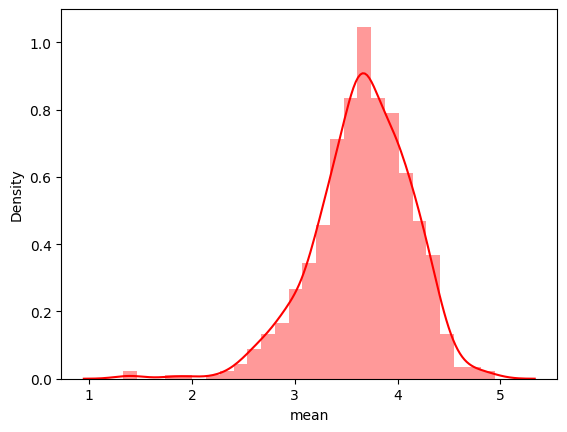

In [ ]:
sns.distplot(a=user_rating_summary['mean'], kde=True, color='r')

<ipython-input-41-7d08273f01ee>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=user_rating_summary['count'], kde=True, color='g')


<Axes: xlabel='count', ylabel='Density'>

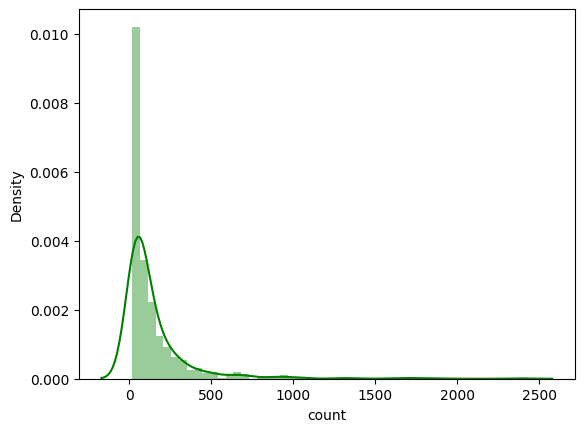

In [ ]:
sns.distplot(a=user_rating_summary['count'], kde=True, color='g')

In [ ]:
def get_movie_name(movie_ratings, movieID):
    return movie_ratings[movie_ratings['movieId'] == movieID][["title", "genres"]].values[0]

def get_movie_id(movie_ratings, movieName):
    return movie_ratings[movie_ratings['title'] == movieName][["movieId", "genres"]].value[0]

In [ ]:
!wget "https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/ratings.csv"

--2023-08-17 04:39:03--  https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/ratings.csv
Resolving grepp-reco-test.s3.ap-northeast-2.amazonaws.com (grepp-reco-test.s3.ap-northeast-2.amazonaws.com)... 52.219.202.38, 3.5.145.112, 52.219.146.82, ...
Connecting to grepp-reco-test.s3.ap-northeast-2.amazonaws.com (grepp-reco-test.s3.ap-northeast-2.amazonaws.com)|52.219.202.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2438266 (2.3M) [text/csv]
Saving to: ‘ratings.csv’

ratings.csv         100%[===================>]   2.33M  2.04MB/s    in 1.1s    

2023-08-17 04:39:05 (2.04 MB/s) - ‘ratings.csv’ saved [2438266/2438266]



In [ ]:
reader = Reader(line_format="user item rating timestamp", sep=",", skip_lines=1)
data = Dataset.load_from_file("ratings.csv", reader=reader)

In [ ]:
from surprise import KNNBasic
import heapq
from collections import defaultdict
from operator import itemgetter

In [ ]:
trainSet = data.build_full_trainset()

In [ ]:
sim_options = {
    "name": "cosine",
    "user_based": True
}

model = KNNBasic(sim_options=sim_options)
model.fit(trainSet)
simMatrix = model.compute_similarities()

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
testUser = '85'
k = 10

# 주어진 사용자와 가장 흡사한 사용자 N을 찾음
# 먼저 이름 Surprise 내부 ID로 변환
testUserInnerId = trainSet.to_inner_uid(testUser)
similarityRow = simMatrix[testUserInnerId]

In [ ]:
# users에 모든 사용자들을 일련번호와 유사도를 갖는 튜플의 형태로 저장
users = []
for innerId, score in enumerate(similarityRow):
    if (innerId != testUserInnerId):
        users.append((innerId, score))

In [ ]:
# 리스트에서 유사도 값을 기준으로 가장 큰 K개를 찾음
kNeighbors = heapq.nlargest(k, users, key=lambda t: t[1])

In [ ]:
# 유사한 사용자들이 평가한 아이템별로 원 사용자와 유사 사용자 간의 유사도를 가중치 평점 누적

# candidate에는 아이템별로 점수를 누적, 유사 사용자 u`의 평점 * 사용자 u와 유사사용자 u`의 유사도
candidates = defaultdict(float)

for similarUser in kNeighbors:
    innerId, userSimilarityScore = similarUser  # (내부ID, 유사도값)

    # innerId에 해당하는 사용자의 아이템과 평점 정보를 읽어온다.
    theirRatings = trainSet.ur[innerId]
    for rating in theirRatings:
        candidates[rating[0]] += (rating[1]) * userSimilarityScore

In [ ]:
# 사용자가 이미 평가한 아이템 삭제
watched = {}
for itemId, rating in trainSet.ur[testUserInnerId]:
    watched[itemId] = 1

In [ ]:
# candidates에서 합산된 스코어를 기준으로 내침차순 소팅
# 사용자(u)가 아직 못본 아이템인 경우 추천
pos = 0
for itemId, ratingSum in sorted(candidates.items(), key=lambda k: k[1], reverse=True):
    if not itemId in watched:
        movieId = trainSet.to_raw_iid(itemId)
        print(movieId, get_movie_name(movie_ratings, int(movieId)), ratingSum)
        pos += 1
        if (pos > 10):
            break

79132 ['Inception (2010)' 'Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX'] 16.5
1196 ['Star Wars: Episode V - The Empire Strikes Back (1980)'
 'Action|Adventure|Sci-Fi'] 12.0
26614 ['Bourne Identity, The (1988)' 'Action|Adventure|Drama|Mystery|Thriller'] 10.0
3996 ['Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)'
 'Action|Drama|Romance'] 10.0
58559 ['Dark Knight, The (2008)' 'Action|Crime|Drama|IMAX'] 10.0
1201 ['Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)'
 'Action|Adventure|Western'] 9.5
48516 ['Departed, The (2006)' 'Crime|Drama|Thriller'] 9.5
91529 ['Dark Knight Rises, The (2012)' 'Action|Adventure|Crime|IMAX'] 9.5
1270 ['Back to the Future (1985)' 'Adventure|Comedy|Sci-Fi'] 9.5
104841 ['Gravity (2013)' 'Action|Sci-Fi|IMAX'] 9.0
2959 ['Fight Club (1999)' 'Action|Crime|Drama|Thriller'] 9.0


In [ ]:
# 함수화
def recommand_for_user(userId):
    testUserInnerId = trainSet.to_inner_uid(userId)
    similarityRow = simMatrix[testUserInnerId]

    users = []
    for innerId, score in enumerate(similarityRow):
        if innerId != testUserInnerId:
            users.append((innerId, score))

    kNeighbors = heapq.nlargest(k, users, key=lambda t: t[1])

    candidates = defaultdict(float)
    for similarUser in kNeighbors:
        innerId, userSimilarityScore = similarUser
        theirRatings = trainSet.ur[innerId]
        for rating in theirRatings:
            candidates[rating[0]] += (rating[1]) * userSimilarityScore

    watched = {}
    for itemId, rating in trainSet.ur[testUserInnerId]:
        watched[itemId] = 1

    pos = 0
    for itemId, ratingSum in sorted(candidates.items(), key=lambda k: k[1], reverse=True):
        if not itemId in watched:
            movieId = trainSet.to_raw_iid(itemId)
            print(movieId, get_movie_name(movie_ratings, int(movieId)), ratingSum)
            pos += 1
            if (pos > 10):
                break


In [ ]:
recommand_for_user('85')

79132 ['Inception (2010)' 'Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX'] 16.5
1196 ['Star Wars: Episode V - The Empire Strikes Back (1980)'
 'Action|Adventure|Sci-Fi'] 12.0
26614 ['Bourne Identity, The (1988)' 'Action|Adventure|Drama|Mystery|Thriller'] 10.0
3996 ['Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)'
 'Action|Drama|Romance'] 10.0
58559 ['Dark Knight, The (2008)' 'Action|Crime|Drama|IMAX'] 10.0
1201 ['Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)'
 'Action|Adventure|Western'] 9.5
48516 ['Departed, The (2006)' 'Crime|Drama|Thriller'] 9.5
91529 ['Dark Knight Rises, The (2012)' 'Action|Adventure|Crime|IMAX'] 9.5
1270 ['Back to the Future (1985)' 'Adventure|Comedy|Sci-Fi'] 9.5
104841 ['Gravity (2013)' 'Action|Sci-Fi|IMAX'] 9.0
2959 ['Fight Club (1999)' 'Action|Crime|Drama|Thriller'] 9.0


## 아이템 기반 유사도 측정

아이템간 유사도 행열을 사용해 변환

In [17]:
from collections import defaultdict

import numpy as np
import pandas as pd

from surprise import Dataset
from surprise import Reader

from sklearn.metrics.pairwise import cosine_similarity

In [18]:
dummy_rating = pd.read_csv("https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/dummy_rating.csv", index_col=0)

In [11]:
dummy_rating.head()

,scifi1,scifi2,scifi3,comedy1,comedy2,comedy3
user1,4.0,5.0,3.0,NaN,2.0,1.0
user2,5.0,3.0,3.0,2.0,2.0,NaN
user3,1.0,NaN,NaN,4.0,5.0,4.0
user4,NaN,2.0,1.0,4.0,NaN,3.0
user5,1.0,NaN,2.0,3.0,3.0,4.0


In [12]:
dummy_rating = dummy_rating.T

In [13]:
dummy_rating.fillna(0, inplace=True)
dummy_rating

,user1,user2,user3,user4,user5
scifi1,4.0,5.0,1.0,0.0,1.0
scifi2,5.0,3.0,0.0,2.0,0.0
scifi3,3.0,3.0,0.0,1.0,2.0
comedy1,0.0,2.0,4.0,4.0,3.0
comedy2,2.0,2.0,5.0,0.0,3.0
comedy3,1.0,0.0,4.0,3.0,4.0


In [14]:
# 피어슨 유사도
def standardize(row):
    new_row = (row - row.mean()) / (row.max() - row.min())
    return new_row

dummy_rating_std = dummy_rating.apply(standardize)
dummy_rating_std.head()

,user1,user2,user3,user4,user5
scifi1,0.3,0.5,-0.266667,-0.416667,-0.291667
scifi2,0.5,0.1,-0.466667,0.083333,-0.541667
scifi3,0.1,0.1,-0.466667,-0.166667,-0.041667
comedy1,-0.5,-0.1,0.333333,0.583333,0.208333
comedy2,-0.1,-0.1,0.533333,-0.416667,0.208333


In [29]:
dummy_rating_std.index

Index(['scifi1', 'scifi2', 'scifi3', 'comedy1', 'comedy2', 'comedy3'], dtype='object')

In [25]:
cosine_similarity(dummy_rating_std)

array([[ 1.        ,  0.62015553,  0.67603117, -0.83359983, -0.18507101,
        -0.97530699],
       [ 0.62015553,  1.        ,  0.62812209, -0.62605785, -0.71658325,
        -0.74308508],
       [ 0.67603117,  0.62812209,  1.        , -0.71567926, -0.5574703 ,
        -0.68276315],
       [-0.83359983, -0.62605785, -0.71567926,  1.        ,  0.06076962,
         0.78722768],
       [-0.18507101, -0.71658325, -0.5574703 ,  0.06076962,  1.        ,
         0.3378109 ],
       [-0.97530699, -0.74308508, -0.68276315,  0.78722768,  0.3378109 ,
         1.        ]])

In [30]:
# 아이템간 유사도 측정 행렬 만들기
corrMatrix = pd.DataFrame(
    cosine_similarity(dummy_rating_std),
    index=dummy_rating_std.index,
    columns=dummy_rating_std.index
)
corrMatrix

,scifi1,scifi2,scifi3,comedy1,comedy2,comedy3
scifi1,1.000000,0.620156,0.676031,-0.833600,-0.185071,-0.975307
scifi2,0.620156,1.000000,0.628122,-0.626058,-0.716583,-0.743085
scifi3,0.676031,0.628122,1.000000,-0.715679,-0.557470,-0.682763
comedy1,-0.833600,-0.626058,-0.715679,1.000000,0.060770,0.787228
comedy2,-0.185071,-0.716583,-0.557470,0.060770,1.000000,0.337811
comedy3,-0.975307,-0.743085,-0.682763,0.787228,0.337811,1.000000


In [33]:
def get_similar(movie_name):
    similar_score = corrMatrix[movie_name]
    similar_score = similar_score.sort_values(ascending=False)
    return similar_score

In [34]:
movie_i_liked = "scifi1"

similar_scores = pd.DataFrame(
    get_similar(movie_i_liked)
)
similar_scores

,scifi1
scifi1,1.000000
scifi3,0.676031
scifi2,0.620156
comedy2,-0.185071
comedy1,-0.833600
comedy3,-0.975307


## 아이템 기반 협업 필터링 구현

In [2]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811608 sha256=cb3719777ea7b68c7da1cb0e40309abcb1c54735c8c3ba42e7cefc41993a1271
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [35]:
!wget "https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/movies.csv"
!wget "https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/ratings.csv"

--2023-08-17 13:39:01--  https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/movies.csv
Resolving grepp-reco-test.s3.ap-northeast-2.amazonaws.com (grepp-reco-test.s3.ap-northeast-2.amazonaws.com)... 52.219.206.74, 52.219.144.74, 52.219.204.70, ...
Connecting to grepp-reco-test.s3.ap-northeast-2.amazonaws.com (grepp-reco-test.s3.ap-northeast-2.amazonaws.com)|52.219.206.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 458390 (448K) [text/csv]
Saving to: ‘movies.csv’

movies.csv          100%[===================>] 447.65K   413KB/s    in 1.1s    

2023-08-17 13:39:03 (413 KB/s) - ‘movies.csv’ saved [458390/458390]

--2023-08-17 13:39:03--  https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/ratings.csv
Resolving grepp-reco-test.s3.ap-northeast-2.amazonaws.com (grepp-reco-test.s3.ap-northeast-2.amazonaws.com)... 52.219.206.74, 52.219.144.74, 52.219.204.70, ...
Connecting to grepp-reco-test.s3.ap-northeast-2.amazonaws.com (grepp-reco-t

In [1]:
# 데이터 로딩
from surprise import Dataset, Reader

from collections import defaultdict
import numpy as np
import pandas as pd

In [2]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
movie_ratings = pd.merge(movies, ratings, left_on="movieId", right_on="movieId")

In [6]:
movie_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,3.0,851866703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9,4.0,938629179
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13,5.0,1331380058
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.0,997938310
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19,3.0,855190091


In [7]:
movies.shape

(9125, 3)

In [8]:
ratings.shape

(100004, 4)

In [9]:
movie_ratings.shape

(100004, 6)

In [10]:
def get_movie_name(movie_ratings, movieID):
    return movie_ratings[movie_ratings["movieId"] == movieID][["title", "genres"]].values[0]

def get_movie_id(movie_ratings, movieName):
    return movie_ratings[movie_ratings["title"] == movieName][["movieId", "genres"]].values[0]

In [11]:
reader = Reader(line_format="user item rating timestamp", sep=",", skip_lines=1)
data = Dataset.load_from_file("ratings.csv", reader=reader)

In [12]:
from surprise import KNNBasic
import heapq

In [13]:
# 데이터를 훈련셋 테스트셋으로 나누지 않고 모두 반환
trainSet = data.build_full_trainset()

In [14]:
sim_options = {
    'name': 'cosine',
    'user_based': False
}

model = KNNBasic(sim_options=sim_options)
model.fit(trainSet)
simMatrix = model.compute_similarities()

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [15]:
simMatrix.shape

(9066, 9066)

In [16]:
testUserId = '85'
k = 10

In [17]:
pd.set_option("display.max_colwidth", -1)
display(movie_ratings[movie_ratings["userId"] == int(testUserId)].sort_values("rating", ascending=False))

<ipython-input-17-8ce4df8640af>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


,movieId,title,genres,userId,rating,timestamp
263,2,Jumanji (1995),Adventure|Children|Fantasy,85,5.0,837511784
7443,255,"Jerky Boys, The (1995)",Comedy,85,5.0,837512635
19363,648,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller,85,5.0,837511448
17405,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,85,5.0,837507044
14386,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,85,5.0,837511743
...,...,...,...,...,...,...
16429,546,Super Mario Bros. (1993),Action|Adventure|Children|Comedy|Fantasy|Sci-Fi,85,1.0,837512482
11769,366,"Wes Craven's New Nightmare (Nightmare on Elm Street Part 7: Freddy's Finale, A) (1994)",Drama|Horror|Mystery|Thriller,85,1.0,837512580
12156,374,Richie Rich (1994),Children|Comedy,85,1.0,837512723
8420,291,Poison Ivy II (1996),Drama|Thriller,85,1.0,837512611


In [17]:
testUserInnerID = trainSet.to_inner_uid(testUserId)
testUserInnerID

84

In [21]:
# 이 사용자가 좋아한 영화 k개를 읽어서 kNeighbors에 저장
testUserRatings = trainSet.ur[testUserInnerID]
print(f"test user ratings length : {len(testUserRatings)}")
kNeighbors = heapq.nlargest(k, testUserRatings, key=lambda t: t[1])
print(f"k neighbors length : {len(kNeighbors)}")

test user ratings length : 107
k neighbors length : 10


In [22]:
kNeighbors

[(650, 5.0),
 (20, 5.0),
 (27, 5.0),
 (4206, 5.0),
 (387, 5.0),
 (49, 5.0),
 (423, 5.0),
 (99, 5.0),
 (145, 5.0),
 (55, 5.0)]

In [ ]:
candidates = defaultdict(float)

for itemID, rating in kNeighbors:
    similarityRow = simMatrix[itemID]
    for innerID, score in enumerate(similarityRow):
        candidates[innerID] += score * (ratings)

650
similarity row length: 9066


In [ ]:
watched = {}
for itemID, rating in trainSet.ur[testUserInnerID]:
    watched[itemID] = 1

In [ ]:
pos = 0
for itemID, ratingSum in sorted(candidates.items(), key=lambda t: t[1], reverse=True):
    if not itemID in watched:
        movieID = trainSet.to_row_iid(itemID)
        print(movieID, get_movie_name(movie_ratings, int(movieID)), ratingSum)
        pos += 1
        if pos > 10:
            break

In [21]:
def recommand_for_item(userID, k=10):
    recommand = []

    testUserInnerID = trainSet.to_inner_uid(userID)
    testUserRatings = trainSet.ur[testUserInnerID]

    kNeighbors = heapq.nlargest(k, testUserRatings, key=lambda t: t[1])

    candidates = defaultdict(float)
    for itemID, rating in kNeighbors:
        similarityRow = simMatrix[itemID]
        for innerID, score in enumerate(similarityRow):
            candidates[innerID] += score * rating

    watched = {}
    for itemID, _ in trainSet.ur[testUserInnerID]:
        watched[itemID] = 1

    pos = 0
    for itemID, ratingSum in sorted(candidates.items(), key=lambda t: t[1], reverse=True):
        if not itemID in watched:
            movieID = trainSet.to_raw_iid(itemID)
            recommand.append([movieID, get_movie_name(movie_ratings, int(movieID)), ratingSum])
            pos += 1
            if pos > 10:
                break
    return recommand

In [22]:
recommand_for_item('85')

[['3136',
  array(['James Dean Story, The (1957)', 'Documentary'], dtype=object),
  50.0],
 ['2607',
  array(['Get Real (1998)', 'Drama|Romance'], dtype=object),
  49.93620560356324],
 ['259',
  array(['Kiss of Death (1995)', 'Crime|Drama|Thriller'], dtype=object),
  49.83440938875971],
 ['998',
  array(['Set It Off (1996)', 'Action|Crime'], dtype=object),
  49.818661078285594],
 ['1935',
  array(['How Green Was My Valley (1941)', 'Drama|Musical|Romance'],
        dtype=object),
  49.71992040532635],
 ['1440',
  array(['Amos & Andrew (1993)', 'Comedy'], dtype=object),
  49.69868472501265],
 ['269',
  array(['My Crazy Life (Mi vida loca) (1993)', 'Drama'], dtype=object),
  49.691452437730206],
 ['988',
  array(['Grace of My Heart (1996)', 'Comedy|Drama'], dtype=object),
  49.631279483226095],
 ['2068',
  array(['Fanny and Alexander (Fanny och Alexander) (1982)',
         'Drama|Fantasy|Mystery'], dtype=object),
  49.628498357279526],
 ['896',
  array(['Wild Reeds (Les roseaux sauvages) 